In [1]:
# %% [markdown]
# ## Cell 1: Import Libraries and Check Setup

# %%
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Check if required packages are installed
import importlib
import sys

packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'statsmodels', 'fredapi', 'scipy']
missing = []

for package in packages:
    try:
        importlib.import_module(package)
        print(f"✓ {package}")
    except ImportError:
        print(f"✗ {package} - MISSING")
        missing.append(package)

if missing:
    print(f"\n⚠️  Install missing packages with: pip install {' '.join(missing)}")
else:
    print("\n✅ All packages installed!")

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline


✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✓ statsmodels
✓ fredapi
✓ scipy

✅ All packages installed!


In [4]:
# %% [markdown]
# ## Cell 2: Configuration - UPDATE THIS!

# %%
# CONFIGURATION - UPDATE THESE VALUES
# ===================================

# Your FRED API key (get free key at: https://fred.stlouisfed.org/docs/api/api_key.html)
FRED_API_KEY = 'bba75ab32d4dc4aedb40f87beac720d3'

# Path to your CRSP data file
CRSP_DATA_PATH = 'Data/crsp-data.pkl'  

# Date range for analysis
START_DATE = '1960-01-01'
END_DATE = '2018-12-31'


import os
if not os.path.exists(CRSP_DATA_PATH):
    print(f"⚠️  CRSP data file not found at: {CRSP_DATA_PATH}")
    print("   Please update CRSP_DATA_PATH with the correct path")
else:
    print("✅ CRSP data file found")


✅ CRSP data file found


In [9]:
# %% [markdown]
# ## Cell 3: Load and Examine CRSP Data

# %%
# Load CRSP data
print("Loading CRSP data...")

if CRSP_DATA_PATH.endswith('.pkl'):
    crsp_data = pd.read_pickle(CRSP_DATA_PATH)
elif CRSP_DATA_PATH.endswith('.csv'):
    crsp_data = pd.read_csv(CRSP_DATA_PATH)
else:
    print("ERROR: File must be .csv or .pkl format")

# Convert date to datetime if needed
if 'date' in crsp_data.columns and not pd.api.types.is_datetime64_any_dtype(crsp_data['date']):
    crsp_data['date'] = pd.to_datetime(crsp_data['date'])

# Display basic information
print(f"\nData shape: {crsp_data.shape}")
print(f"Date range: {crsp_data['date'].min()} to {crsp_data['date'].max()}")
print(f"Number of unique stocks: {crsp_data['permno'].nunique():,}")

# Show columns
print("\nColumns in dataset:")
print(list(crsp_data.columns))

# Show sample data
print("\nFirst few rows:")
crsp_data.head()

# %%
# Check data quality
print("Data quality check:")
print("-" * 50)

# Check for required columns
required_cols = ['date', 'permno', 'ret', 'BM', 'market_equity']
missing_cols = [col for col in required_cols if col not in crsp_data.columns]

crsp_data['BM'] = abs(crsp_data['BM'])

if missing_cols:
    print(f"❌ Missing required columns: {missing_cols}")
else:
    print("✅ All required columns present")

# Check for missing values
print(f"\nMissing values:")
for col in required_cols:
    if col in crsp_data.columns:
        missing_pct = crsp_data[col].isna().mean() * 100
        print(f"  {col}: {missing_pct:.1f}%")

# Basic statistics
print("\nBasic statistics for key variables:")
crsp_data[['ret', 'BM', 'market_equity']].describe()


Loading CRSP data...

Data shape: (2450653, 74)
Date range: 1960-01-01 00:00:00 to 2018-12-01 00:00:00
Number of unique stocks: 20,435

Columns in dataset:
['permno', 'date', 'nameendt', 'shrcd', 'exchcd', 'siccd', 'ncusip', 'ticker', 'comnam', 'shrcls', 'tsymbol', 'naics', 'primexch', 'trdstat', 'secstat', 'permco', 'issuno', 'hexcd', 'hsiccd', 'cusip', 'dclrdt', 'dlamt', 'dlpdt', 'dlstcd', 'nextdt', 'paydt', 'rcrddt', 'shrflg', 'hsicmg', 'hsicig', 'distcd', 'divamt', 'facpr', 'facshr', 'acperm', 'accomp', 'shrenddt', 'nwperm', 'dlretx', 'dlprc', 'dlret', 'trtscd', 'nmsind', 'mmcnt', 'nsdinx', 'bidlo', 'askhi', 'prc', 'vol', 'ret', 'bid', 'ask', 'shrout', 'cfacpr', 'cfacshr', 'altprc', 'spread', 'altprcdt', 'retx', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn', 'yyyymm', 'BM', 'adj_price', 'adj_shrout', 'adj_dividend', 'market_equity', 'book_equity', 'log_ret', 'fiscal_year', 'dividend_yield']

First few rows:
Data quality check:
--------------------------------------------------
✅

,ret,BM,market_equity
count,2.450653e+06,2.450653e+06,2.450653e+06
mean,1.214915e-02,9.231580e-01,1.646972e+09
std,1.756965e-01,8.284295e-01,1.160374e+10
min,-9.838762e-01,7.696094e-09,1.056250e+04
25%,-6.481481e-02,3.212273e-01,2.309875e+07
50%,0.000000e+00,7.016396e-01,9.918700e+07
75%,7.146974e-02,1.289357e+00,5.015597e+08
max,2.400000e+01,1.013099e+01,1.099436e+12


In [36]:
ls_ret_df = pd.read_csv('Data/long_short_returns_clean.csv', index_col='date')
long_return = ls_ret_df['long_return']
short_return = ls_ret_df['short_return']
ls_ret = ls_ret_df['long_short_return']
long_return.index = pd.to_datetime(long_return.index)
short_return.index = pd.to_datetime(short_return.index)
ls_ret.index = pd.to_datetime(ls_ret.index)
ls_ret_df

,long_return,short_return,long_short_return,long_stocks,short_stocks,cumulative_return
date,,,,,,
1961-07-31,0.015122,0.012407,0.002714,121,122,0.002714
1961-08-31,0.019149,0.031121,-0.011972,121,123,-0.009290
1961-09-30,-0.030966,-0.032465,0.001499,121,123,-0.007804
1961-10-31,0.021417,0.015377,0.006040,122,123,-0.001811
1961-11-30,0.051985,0.041576,0.010409,122,123,0.008579
...,...,...,...,...,...,...
2018-02-28,-0.038845,-0.037385,-0.001459,805,713,11.893234
2018-03-31,0.022017,0.003969,0.018048,804,711,12.125936
2018-04-30,0.011687,0.000477,0.011210,798,708,12.273081



HML Summary Statistics:
--------------------------------------------------
Full sample: Mean=0.0040, Std=0.0249, Sharpe=0.5624
Pre-2008:    Mean=0.0049, Sharpe=0.6554
Post-2008:   Mean=0.0003, Sharpe=0.0504


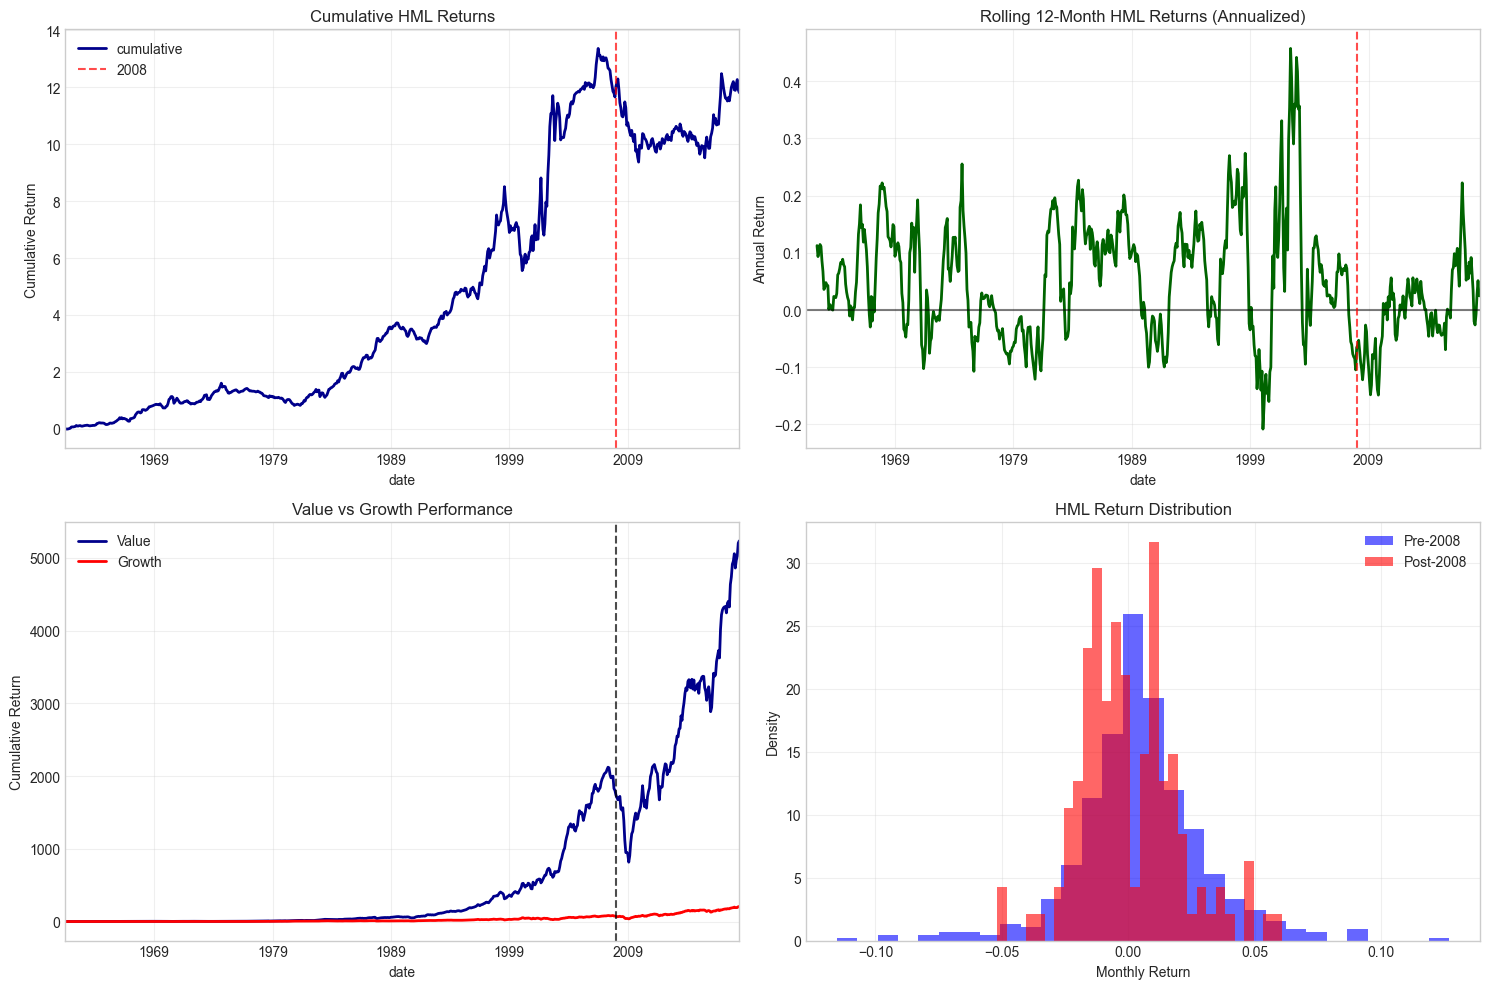

In [34]:
# %% [markdown]
# ## Cell 4: Calculate HML Returns

# %%

# Display summary statistics
print("\nHML Summary Statistics:")
print("-" * 50)
hml_returns = pd.DataFrame()
# Overall
mean_ret = ls_ret.mean()
std_ret = ls_ret.std()
sharpe = mean_ret / std_ret * np.sqrt(12)

print(f"Full sample: Mean={mean_ret:.4f}, Std={std_ret:.4f}, Sharpe={sharpe:.4f}")

# Pre/Post 2008
pre_2008 = ls_ret[ls_ret.index < '2008-01-01']
post_2008 = ls_ret[ls_ret.index >= '2008-01-01']

print(f"Pre-2008:    Mean={pre_2008.mean():.4f}, Sharpe={pre_2008.mean()/pre_2008.std()*np.sqrt(12):.4f}")
print(f"Post-2008:   Mean={post_2008.mean():.4f}, Sharpe={post_2008.mean()/post_2008.std()*np.sqrt(12):.4f}")

# %%
# Visualize HML performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Cumulative returns
ax = axes[0, 0]
hml_returns['cumulative'] = (1 + ls_ret).cumprod() -1
hml_returns['cumulative'].plot(ax=ax, linewidth=2, color='darkblue')
ax.axvline(pd.Timestamp('2008-01-01'), color='red', linestyle='--', alpha=0.7, label='2008')
ax.set_title('Cumulative HML Returns')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Rolling 12-month returns
ax = axes[0, 1]
hml_returns['rolling_annual'] = ls_ret.rolling(12).mean() * 12
hml_returns['rolling_annual'].plot(ax=ax, linewidth=2, color='darkgreen')
ax.axhline(0, color='black', linestyle='-', alpha=0.5)
ax.axvline(pd.Timestamp('2008-01-01'), color='red', linestyle='--', alpha=0.7)
ax.set_title('Rolling 12-Month HML Returns (Annualized)')
ax.set_ylabel('Annual Return')
ax.grid(True, alpha=0.3)

# 3. Value vs Growth separately
ax = axes[1, 0]
value_cum = (1 + long_return).cumprod() -1
growth_cum = (1 + short_return).cumprod() -1
value_cum.plot(ax=ax, label='Value', linewidth=2, color='darkblue')
growth_cum.plot(ax=ax, label='Growth', linewidth=2, color='red')
ax.axvline(pd.Timestamp('2008-01-01'), color='black', linestyle='--', alpha=0.7)
ax.set_title('Value vs Growth Performance')
ax.set_ylabel('Cumulative Return')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Monthly returns distribution
ax = axes[1, 1]
pre_2008.hist(ax=ax, bins=30, alpha=0.6, label='Pre-2008', color='blue', density=True)
post_2008.hist(ax=ax, bins=30, alpha=0.6, label='Post-2008', color='red', density=True)
ax.set_title('HML Return Distribution')
ax.set_xlabel('Monthly Return')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [12]:
# %% [markdown]
# ## Cell 5: Fetch FRED Data

# %%
from fredapi import Fred

# Initialize FRED API
fred = Fred(api_key=FRED_API_KEY)

print("Fetching data from FRED...")

# Dictionary of series to fetch
fred_series = {
    # Treasury yields for term structure
    'DGS3MO': 'y3m',
    'DGS1': 'y1',
    'DGS2': 'y2',
    'DGS5': 'y5',
    'DGS10': 'y10',
    'DGS30': 'y30',
    'T10Y2Y': 'term_spread_10_2',
    'DFII10': 'tips_10y',
    
    # Fed balance sheet and policy
    'WALCL': 'fed_assets',
    'FEDFUNDS': 'fed_funds',
    'WSHOSHO': 'fed_securities',
    
    # Market conditions
    'VIXCLS': 'vix',
    'TEDRATE': 'ted_spread',
}

# Fetch all series
fred_data = pd.DataFrame()

for fred_code, col_name in fred_series.items():
    try:
        series = fred.get_series(fred_code, observation_start=START_DATE, observation_end=END_DATE)
        fred_data[col_name] = series
        print(f"  ✓ {col_name}")
    except Exception as e:
        print(f"  ✗ {col_name}: {str(e)[:50]}...")

# Resample to monthly
fred_data = fred_data.resample('M').last()

print(f"\n✅ Fetched {len(fred_data.columns)} series")
print(f"Date range: {fred_data.index.min()} to {fred_data.index.max()}")

# Show what we got
fred_data.info()

Fetching data from FRED...
  ✓ y3m
  ✓ y1
  ✓ y2
  ✓ y5
  ✓ y10
  ✓ y30
  ✓ term_spread_10_2
  ✓ tips_10y
  ✓ fed_assets
  ✓ fed_funds
  ✓ fed_securities
  ✓ vix
  ✓ ted_spread

✅ Fetched 13 series
Date range: 1981-09-30 00:00:00 to 2018-12-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 448 entries, 1981-09-30 to 2018-12-31
Freq: ME
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   y3m               448 non-null    float64
 1   y1                448 non-null    float64
 2   y2                448 non-null    float64
 3   y5                448 non-null    float64
 4   y10               448 non-null    float64
 5   y30               448 non-null    float64
 6   term_spread_10_2  448 non-null    float64
 7   tips_10y          192 non-null    float64
 8   fed_assets        193 non-null    float64
 9   fed_funds         320 non-null    float64
 10  fed_securities    193 non-null    float64
 11

In [17]:
hml_returns

,hml,value_ret,growth_ret,n_value,n_growth,value_mktcap,growth_mktcap,cumulative,rolling_annual
date,,,,,,,,,
1960-01-01,-0.031805,-0.091105,-0.059300,122,122,9.557560e+10,1.532070e+10,0.968195,NaN
1960-02-01,0.023995,0.022384,-0.001611,122,122,9.702543e+10,1.515417e+10,0.991427,NaN
1960-03-01,0.027959,-0.002131,-0.030091,122,122,9.649833e+10,1.459148e+10,1.019146,NaN
1960-04-01,0.015277,-0.006951,-0.022228,122,122,9.549979e+10,1.478531e+10,1.034716,NaN
1960-05-01,0.052632,0.061819,0.009187,122,122,1.007764e+11,1.477868e+10,1.089175,NaN
...,...,...,...,...,...,...,...,...,...
2018-08-01,0.070916,0.073516,0.002600,854,884,1.118696e+13,3.231448e+12,0.210907,0.136480
2018-09-01,0.001261,0.004206,0.002944,861,873,1.116759e+13,3.182026e+12,0.211173,0.168954
2018-10-01,-0.016960,-0.086026,-0.069066,858,863,1.006843e+13,2.916492e+12,0.207591,0.145913


Analyzing term structure impact on HML...
Analysis dataset: 442 observations
1. Basic Term Structure Impact:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      3.008      0.003       0.002       0.007
d_level       -0.0078      0.005     -1.649      0.099      -0.017       0.001
d_slope        0.0058      0.009      0.678      0.497      -0.011       0.023

Interpretation:
- 1% increase in yield level → -0.0078 change in HML
- 1% steepening of curve → 0.0058 change in HML

2. Regime-Dependent Effects:
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0061      0.002      3.121      0.002       0.002       0.010
d_level          -0.0077      0.004     -1.783      0.075      -0.016       0.001
low_rate         -0.

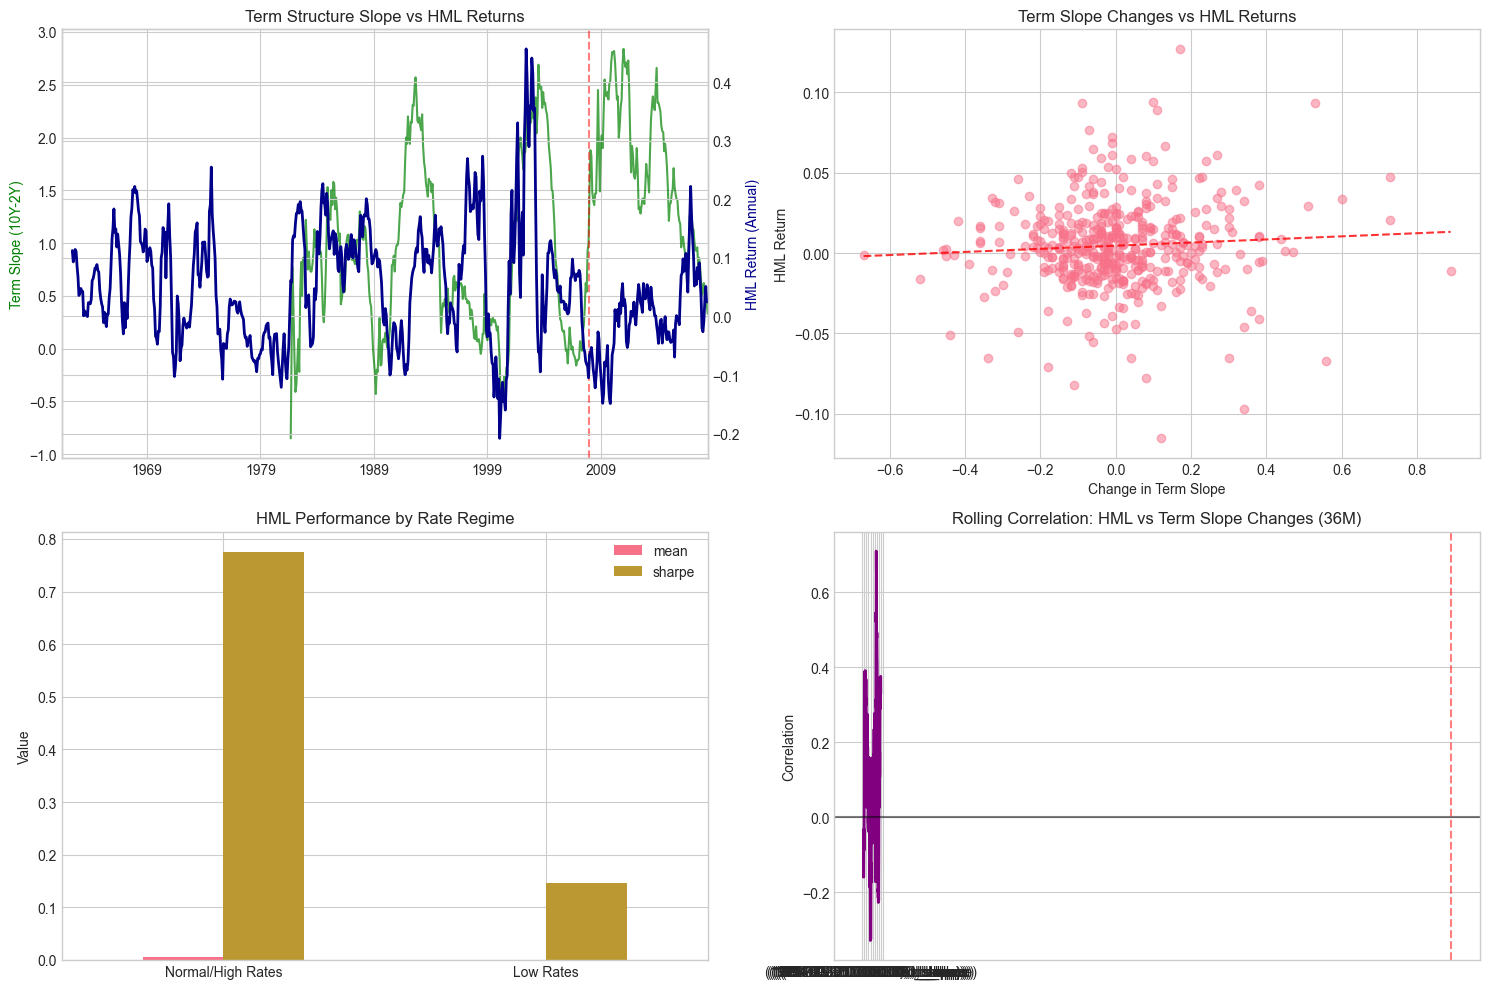

In [60]:
# %% [markdown]
# ## Cell 6: Term Structure Analysis

# %%
# Calculate term structure variables
print("Analyzing term structure impact on HML...")

# Create term structure variables
ts_data = fred_data.copy()

# Calculate level, slope, curvature
yield_cols = [col for col in ['y1', 'y2', 'y5', 'y10'] if col in ts_data.columns]
if len(yield_cols) >= 3:
    ts_data['level'] = ts_data[yield_cols].mean(axis=1)
    ts_data['slope'] = ts_data['y10'] - ts_data['y2'] if all(c in ts_data.columns for c in ['y10', 'y2']) else np.nan
    ts_data['curvature'] = 2*ts_data['y5'] - ts_data['y2'] - ts_data['y10'] if all(c in ts_data.columns for c in ['y2', 'y5', 'y10']) else np.nan

# Calculate changes
for var in ['level', 'slope', 'y10', 'y2']:
    if var in ts_data.columns:
        ts_data[f'd_{var}'] = ts_data[var].diff()

# Merge with HML returns
analysis_df = pd.merge(ls_ret_df[['long_short_return', 'long_return', 'short_return']], ts_data, 
                       left_index=True, right_index=True, how='inner')

print(f"Analysis dataset: {len(analysis_df)} observations")

# %%
# Run term structure regressions

print("1. Basic Term Structure Impact:")
print("=" * 60)

# Model 1: HML on level and slope changes
if all(var in analysis_df.columns for var in ['d_level', 'd_slope']):
    X = sm.add_constant(analysis_df[['d_level', 'd_slope']].dropna())
    y = analysis_df.loc[X.index, 'long_short_return']
    
    model1 = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
    print(model1.summary().tables[1])
    
    print(f"\nInterpretation:")
    print(f"- 1% increase in yield level → {model1.params['d_level']:.4f} change in HML")
    print(f"- 1% steepening of curve → {model1.params['d_slope']:.4f} change in HML")

# %%
# Regime-dependent analysis

print("\n2. Regime-Dependent Effects:")
print("=" * 60)

# Check if we have 'level' data
if 'level' in analysis_df.columns and not analysis_df['level'].isna().all():
    # Define rate regimes
    analysis_df['low_rate'] = (analysis_df['level'] < analysis_df['level'].quantile(0.33)).astype(int)
    analysis_df['high_rate'] = (analysis_df['level'] > analysis_df['level'].quantile(0.67)).astype(int)
    
    # Interaction terms
    if 'd_level' in analysis_df.columns:
        analysis_df['d_level_x_low'] = analysis_df['d_level'] * analysis_df['low_rate']
        
        # Model 2: With regime interactions
        # First check if we have enough data
        reg_vars = ['d_level', 'low_rate', 'd_level_x_low']
        reg_data = analysis_df[['long_short_return'] + reg_vars].dropna()
        
        if len(reg_data) > 20:  # Need sufficient observations
            X = sm.add_constant(reg_data[reg_vars])
            y = reg_data['long_short_return']
            
            try:
                model2 = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
                print(model2.summary().tables[1])
                
                print(f"\nRate sensitivity by regime:")
                print(f"- Normal rates: {model2.params['d_level']:.4f}")
                print(f"- Low rates: {model2.params['d_level'] + model2.params['d_level_x_low']:.4f}")
            except Exception as e:
                print(f"Could not estimate regime model: {e}")
        else:
            print("Not enough data for regime analysis")
else:
    print("Level data not available for regime analysis")

# %%
# Visualize term structure impact

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Term slope over time
ax = axes[0, 0]
if 'slope' in analysis_df.columns:
    analysis_df['slope'].plot(ax=ax, color='green', alpha=0.7)
    ax2 = ax.twinx()
    hml_returns['rolling_annual'].plot(ax=ax2, color='darkblue', linewidth=2)
    ax.set_ylabel('Term Slope (10Y-2Y)', color='green')
    ax2.set_ylabel('HML Return (Annual)', color='darkblue')
    ax.set_title('Term Structure Slope vs HML Returns')
    ax.axvline(pd.Timestamp('2008-01-01'), color='red', linestyle='--', alpha=0.5)

# 2. Scatter plot: slope changes vs HML
ax = axes[0, 1]
if 'd_slope' in analysis_df.columns:
    mask = ~analysis_df[['d_slope', 'long_short_return']].isna().any(axis=1)
    ax.scatter(analysis_df.loc[mask, 'd_slope'], analysis_df.loc[mask, 'long_short_return'], alpha=0.5)
    
    # Add regression line
    z = np.polyfit(analysis_df.loc[mask, 'd_slope'], analysis_df.loc[mask, 'long_short_return'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(analysis_df['d_slope'].min(), analysis_df['d_slope'].max(), 100)
    ax.plot(x_line, p(x_line), "r--", alpha=0.8)
    
    ax.set_xlabel('Change in Term Slope')
    ax.set_ylabel('HML Return')
    ax.set_title('Term Slope Changes vs HML Returns')

# 3. Rate level regimes
ax = axes[1, 0]
regime_performance = analysis_df.groupby('low_rate')['long_short_return'].agg(['mean', 'std', 'count'])
regime_performance['sharpe'] = regime_performance['mean'] / regime_performance['std'] * np.sqrt(12)
regime_performance.index = ['Normal/High Rates', 'Low Rates']
regime_performance[['mean', 'sharpe']].plot(kind='bar', ax=ax)
ax.set_title('HML Performance by Rate Regime')
ax.set_ylabel('Value')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# 4. Time-varying sensitivity
ax = axes[1, 1]
# Calculate rolling correlation
rolling_corr = analysis_df[['long_short_return', 'd_slope']].rolling(window=36).corr().iloc[1::2, 0]
rolling_corr.plot(ax=ax, linewidth=2, color='purple')
ax.axhline(0, color='black', linestyle='-', alpha=0.5)
ax.axvline(pd.Timestamp('2008-01-01'), color='red', linestyle='--', alpha=0.5)
ax.set_title('Rolling Correlation: HML vs Term Slope Changes (36M)')
ax.set_ylabel('Correlation')

plt.tight_layout()
plt.show()

QE periods defined. Analyzing impact...
1. HML Performance During QE vs Non-QE Periods:
            mean       std  count    sharpe
Non-QE  0.005720  0.028203    380  0.702560
QE     -0.001874  0.017315     62 -0.374884

T-test: t-statistic = -2.057, p-value = 0.040

2. Performance by QE Program:
----------------------------------------
QE1        Mean: -0.0079  Std: 0.0260  N: 17
QE2        Mean: -0.0014  Std: 0.0122  N: 8
Op_Twist   Mean: 0.0031  Std: 0.0134  N: 16
QE3        Mean: 0.0004  Std: 0.0124  N: 25

3. Fed Balance Sheet Impact:
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0016      0.002      0.884      0.377      -0.002       0.005
fed_assets_growth     0.0307      0.008      3.711      0.000       0.015       0.047
any_qe               -0.0039      0.003     -1.516      0.129      -0.009       0.001


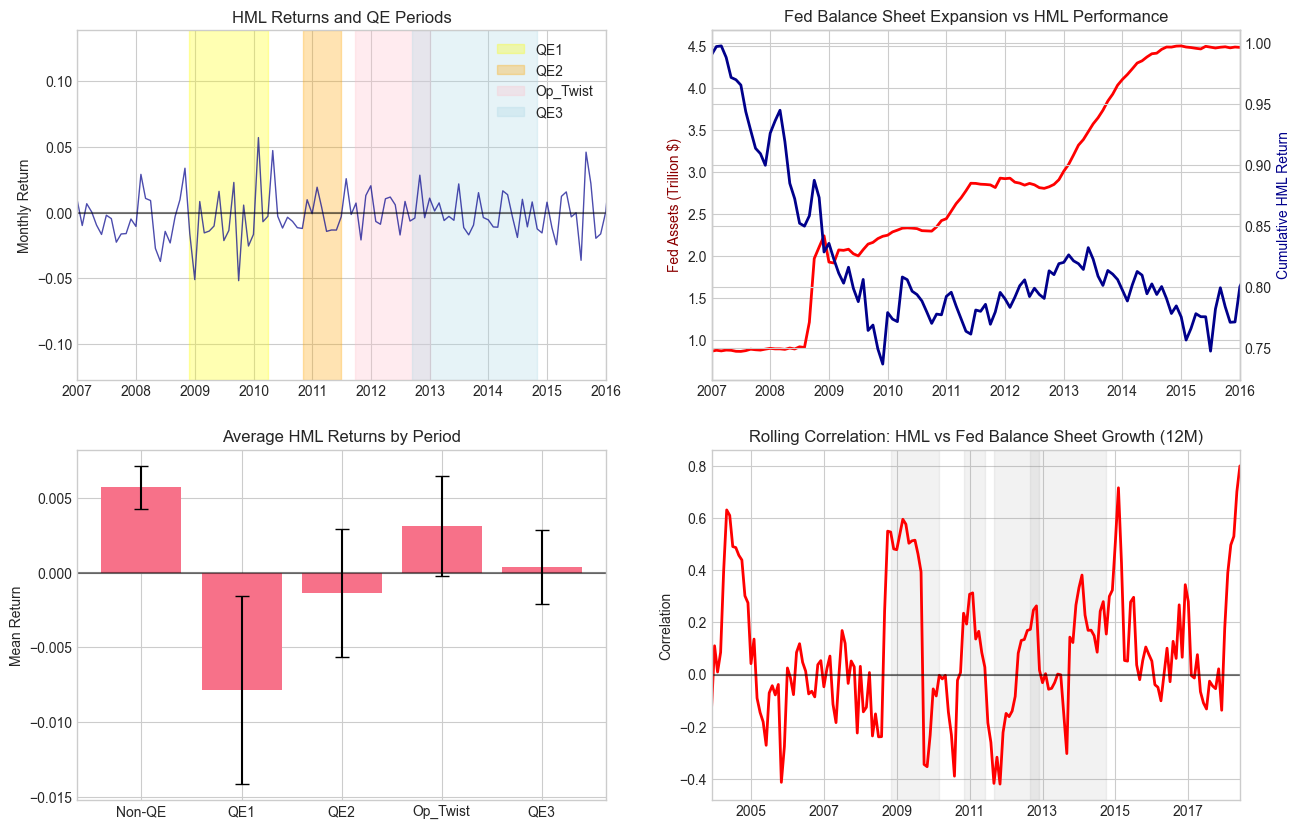

In [71]:
# ## Cell 7: QE Impact Analysis

# %%
# Define QE periods
qe_periods = [
    ('QE1', '2008-11-25', '2010-03-31'),
    ('QE2', '2010-11-03', '2011-06-30'),
    ('Op_Twist', '2011-09-21', '2012-12-31'),
    ('QE3', '2012-09-13', '2014-10-29'),
]

# Create QE indicator variables
qe_df = pd.DataFrame(index=analysis_df.index)
qe_df['any_qe'] = 0

for name, start, end in qe_periods:
    qe_df[name] = 0
    mask = (qe_df.index >= start) & (qe_df.index <= end)
    qe_df.loc[mask, name] = 1
    qe_df.loc[mask, 'any_qe'] = 1

# Merge with analysis dataframe
analysis_df2 = pd.merge(analysis_df, qe_df, left_index=True, right_index=True)

# Calculate Fed balance sheet growth
if 'fed_assets' in analysis_df2.columns:
    analysis_df2['fed_assets_log'] = np.log(analysis_df2['fed_assets'])
    analysis_df2['fed_assets_growth'] = analysis_df2['fed_assets'].pct_change()
    analysis_df2['fed_assets_ma'] = analysis_df2['fed_assets_growth'].rolling(3).mean()

print("QE periods defined. Analyzing impact...")

# %%
# QE impact analysis

print("1. HML Performance During QE vs Non-QE Periods:")
print("=" * 60)

# Group by QE/non-QE
qe_comparison = analysis_df2.groupby('any_qe')['long_short_return'].agg(['mean', 'std', 'count'])
qe_comparison['sharpe'] = qe_comparison['mean'] / qe_comparison['std'] * np.sqrt(12)
qe_comparison.index = ['Non-QE', 'QE']
print(qe_comparison)

# Statistical test
qe_returns = analysis_df2[analysis_df2['any_qe'] == 1]['long_short_return'].dropna()
non_qe_returns = analysis_df2[analysis_df2['any_qe'] == 0]['long_short_return'].dropna()
t_stat, p_value = stats.ttest_ind(qe_returns, non_qe_returns)
print(f"\nT-test: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")

# Individual QE programs
print("\n2. Performance by QE Program:")
print("-" * 40)
for program in ['QE1', 'QE2', 'Op_Twist', 'QE3']:
    if program in analysis_df2.columns:
        program_data = analysis_df2[analysis_df2[program] == 1]['long_short_return']
        if len(program_data) > 0:
            print(f"{program:10} Mean: {program_data.mean():6.4f}  Std: {program_data.std():6.4f}  N: {len(program_data)}")

# %%
# Fed balance sheet regression

print("\n3. Fed Balance Sheet Impact:")
print("=" * 60)

if 'fed_assets_growth' in analysis_df2.columns:
    # Model with Fed balance sheet growth
    X = sm.add_constant(analysis_df2[['fed_assets_growth', 'any_qe']].dropna())
    y = analysis_df2.loc[X.index, 'long_short_return']
    
    model_fed = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
    print(model_fed.summary().tables[1])

# %%
# Visualize QE impact

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. HML returns with QE periods shaded
ax = axes[0, 0]
ax.plot(analysis_df2.index, analysis_df2['long_short_return'], color='darkblue', alpha=0.7, linewidth=1)

# Shade QE periods
colors = ['yellow', 'orange', 'pink', 'lightblue']
for (name, start, end), color in zip(qe_periods, colors):
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.3, color=color, label=name)

ax.axhline(0, color='black', linestyle='-', alpha=0.5)
ax.set_title('HML Returns and QE Periods')
ax.set_ylabel('Monthly Return')
ax.legend(loc='upper right')
ax.set_xlim(pd.Timestamp('2007-01-01'), pd.Timestamp('2016-01-01'))

# 2. Fed balance sheet vs HML cumulative
ax = axes[0, 1]
if 'fed_assets' in analysis_df2.columns:
    ax2 = ax.twinx()
    
    # Fed assets in trillions
    (analysis_df2['fed_assets'] / 1e6).plot(ax=ax, color='red', linewidth=2, label='Fed Assets')
    
    # Cumulative HML since 2007
    hml_2007 = analysis_df2.loc['2007-01-01':, 'long_short_return']
    hml_cum_2007 = (1 + hml_2007).cumprod() #Cumulative Return from after the 2007
    hml_cum_2007.plot(ax=ax2, color='darkblue', linewidth=2, label='Cumulative HML')
    
    ax.set_ylabel('Fed Assets (Trillion $)', color='darkred')
    ax2.set_ylabel('Cumulative HML Return', color='darkblue')
    ax.set_title('Fed Balance Sheet Expansion vs HML Performance')
    ax.set_xlim(pd.Timestamp('2007-01-01'), pd.Timestamp('2016-01-01'))

# 3. Average returns by QE program
ax = axes[1, 0]
qe_means = []
qe_stds = []
qe_names = []

for program in ['Non-QE', 'QE1', 'QE2', 'Op_Twist', 'QE3']:
    if program == 'Non-QE':
        data = analysis_df2[analysis_df2['any_qe'] == 0]['long_short_return']
    elif program in analysis_df2.columns:
        data = analysis_df2[analysis_df2[program] == 1]['long_short_return']
    else:
        continue
    
    if len(data) > 0:
        qe_means.append(data.mean())
        qe_stds.append(data.std() / np.sqrt(len(data)))  # Standard error
        qe_names.append(program)

x = np.arange(len(qe_names))
ax.bar(x, qe_means, yerr=qe_stds, capsize=5)
ax.set_xticks(x)
ax.set_xticklabels(qe_names)
ax.axhline(0, color='black', linestyle='-', alpha=0.5)
ax.set_title('Average HML Returns by Period')
ax.set_ylabel('Mean Return')

# 4. Rolling correlation with Fed balance sheet growth
ax = axes[1, 1]
if 'fed_assets_growth' in analysis_df2.columns:

    # Compute rolling correlation (36-month window)
    rolling_corr = (
        analysis_df2['long_short_return']
        .rolling(window=12)
        .corr(analysis_df2['fed_assets_growth'])
    )

    # Drop NaNs to identify valid range
    valid_corr = rolling_corr.dropna()

    # Plot only if there's enough data
    if not valid_corr.empty:
        valid_corr.plot(ax=ax, linewidth=2, color='red')
        ax.axhline(0, color='black', linestyle='-', alpha=0.5)
        ax.set_title('Rolling Correlation: HML vs Fed Balance Sheet Growth (12M)')
        ax.set_ylabel('Correlation')

        # Restrict x-axis to valid correlation data
        ax.set_xlim(valid_corr.index.min(), valid_corr.index.max())

        # Mark QE periods that fall within this range
        for name, start, end in qe_periods:
            start_ts = pd.Timestamp(start)
            end_ts = pd.Timestamp(end)
            if end_ts >= valid_corr.index.min() and start_ts <= valid_corr.index.max():
                ax.axvspan(start_ts, end_ts, alpha=0.1, color='gray')


#plt.tight_layout()
plt.show()

In [87]:
ls_ret_df

,long_return,short_return,long_short_return,long_stocks,short_stocks,cumulative_return
date,,,,,,
1961-07-31,0.015122,0.012407,0.002714,121,122,0.002714
1961-08-31,0.019149,0.031121,-0.011972,121,123,-0.009290
1961-09-30,-0.030966,-0.032465,0.001499,121,123,-0.007804
1961-10-31,0.021417,0.015377,0.006040,122,123,-0.001811
1961-11-30,0.051985,0.041576,0.010409,122,123,0.008579
...,...,...,...,...,...,...
2018-02-28,-0.038845,-0.037385,-0.001459,805,713,11.893234
2018-03-31,0.022017,0.003969,0.018048,804,711,12.125936
2018-04-30,0.011687,0.000477,0.011210,798,708,12.273081


1. Calculating rolling correlation measures...
date
1960-01-01   -0.080339
1960-02-01    0.010576
1960-03-01   -0.012603
1960-04-01   -0.014576
1960-05-01    0.044002
Name: market_ret, dtype: float64
2. Calculating volatility-based measures...
3. Calculating drawdown measures...
4. Calculating stability measures...
5. Calculating performance-based measures...
6. Calculating extreme return measures...
7. Creating composite crowding indices...


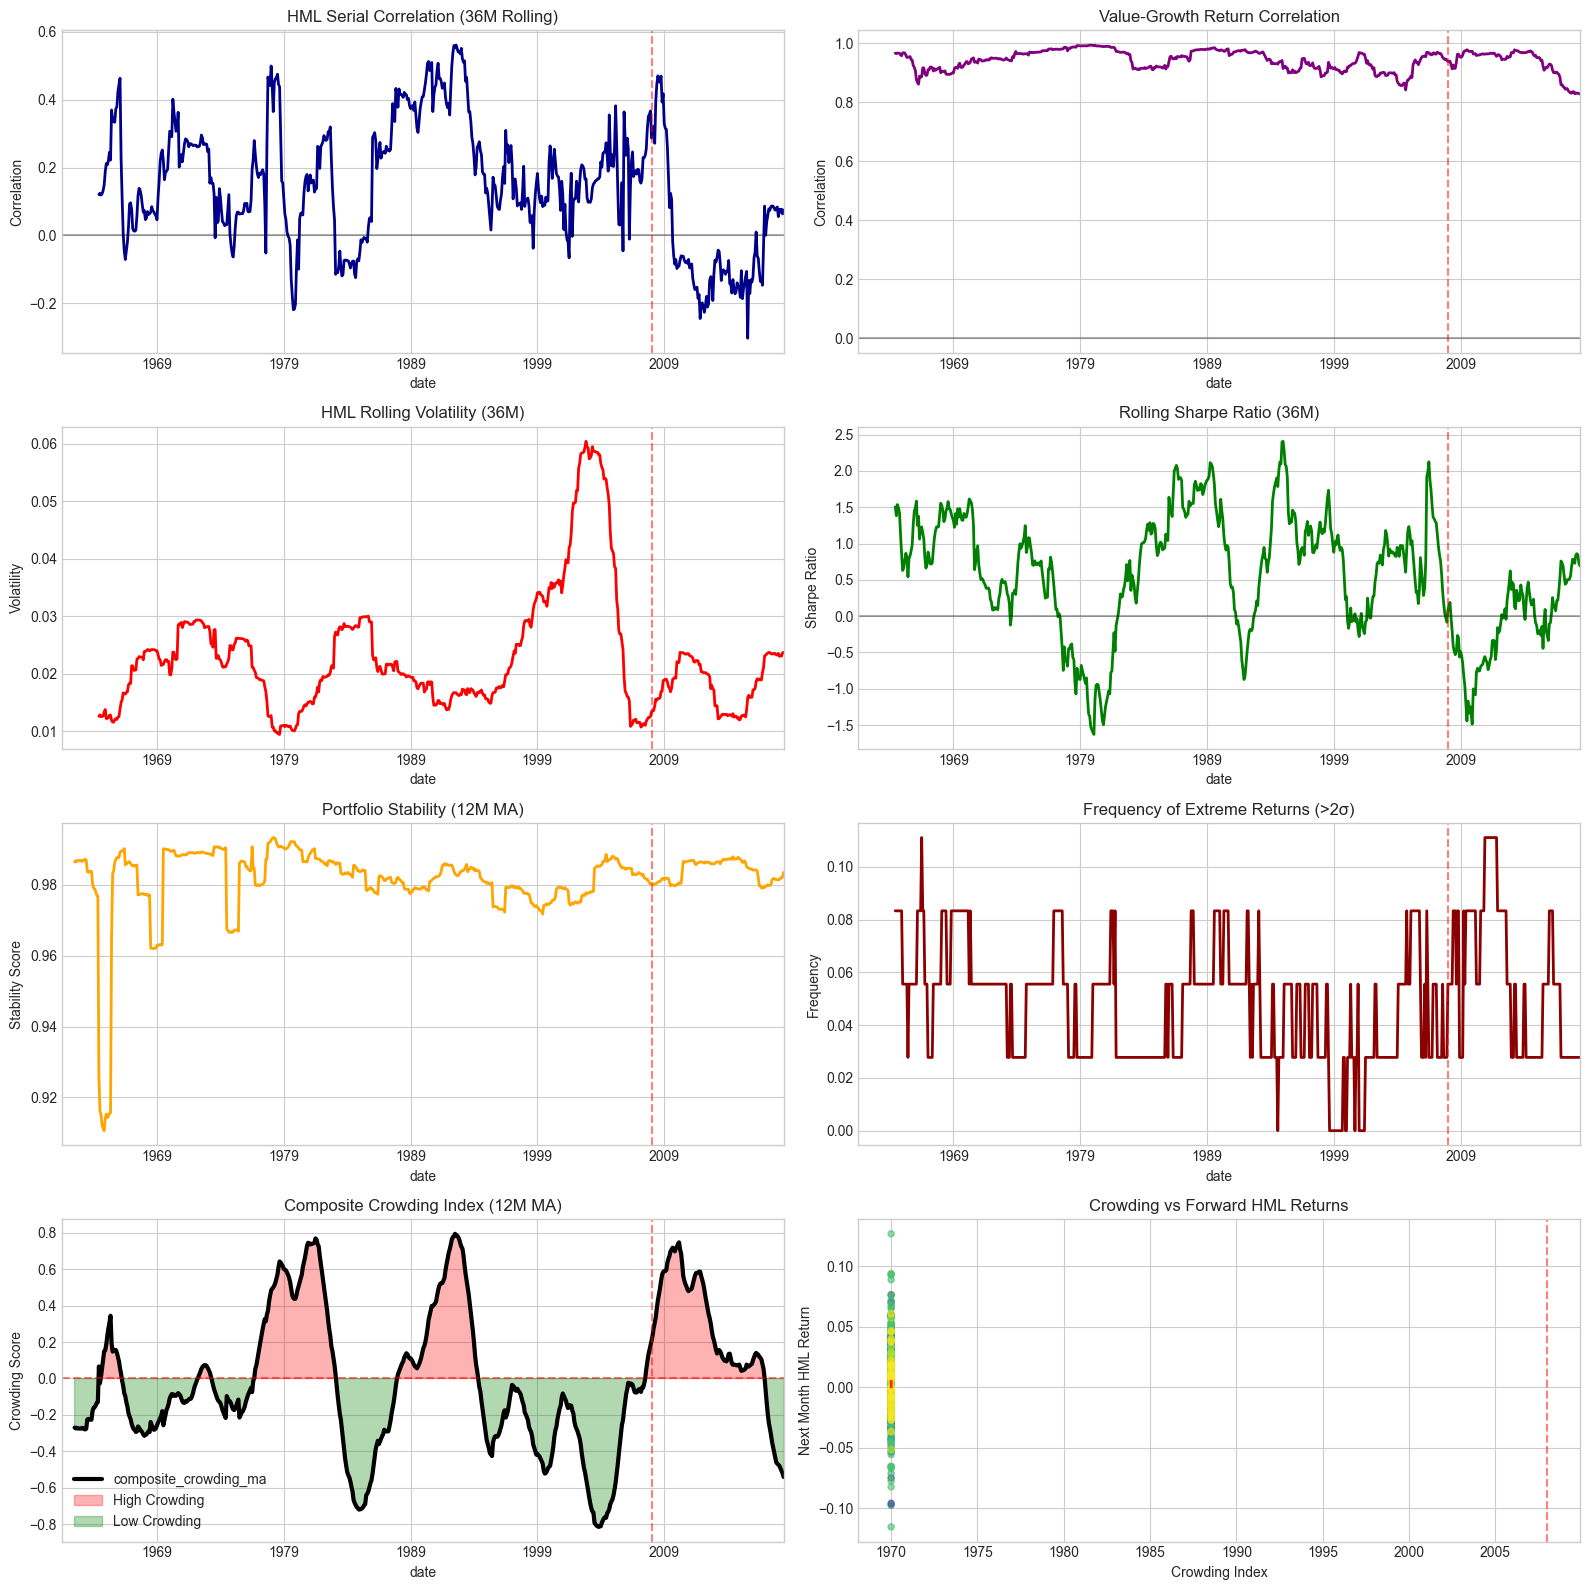

CROWDING IMPACT ANALYSIS

1. Contemporaneous Relationship:
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0040      0.001      3.853      0.000       0.002       0.006
composite_crowding    -0.0043      0.002     -2.051      0.040      -0.008      -0.000

2. Predictive Relationship (Crowding → Future Returns):

3. Performance in High vs Low Crowding Regimes:

                    mean       std  count    sharpe
Low Crowding   0.005972  0.029564    343  0.699752
High Crowding  0.002106  0.018970    341  0.384558

T-test for difference: t=2.034, p-value=0.042

4. Individual Crowding Measures Impact:

hml_serial_corr          : coef= 0.0015, t=  0.27

value_growth_corr        : coef=-0.0532, t= -1.91

hml_volatility           : coef= 0.2377, t=  2.50

sharpe_ratio             : coef= 0.0051, t=  4.22

extreme_return_freq      : coef=-0.0301

In [110]:
# %% [markdown]
# ## Alternative Crowding Measures Using Your HML Returns DataFrame

# %%
def calculate_crowding_from_hml_data(hml_df, crsp_data=None):
    """
    Calculate various crowding measures using the HML returns dataframe
    
    Parameters:
    -----------
    hml_df : DataFrame with columns ['hml', 'value_ret', 'growth_ret', 'n_value', 'n_growth']
    crsp_data : Optional original CRSP data for additional measures
    
    Returns:
    --------
    DataFrame with various crowding measures
    """
    
    crowding = pd.DataFrame(index=hml_df.index)
    
    # 1. ROLLING CORRELATION MEASURES
    print("1. Calculating rolling correlation measures...")
    
    # 1a. Serial correlation of HML returns (momentum in the strategy)
    # High serial correlation suggests crowding as everyone follows same signals
    crowding['hml_serial_corr'] = hml_df['long_short_return'].rolling(36).apply(
        lambda x: x.autocorr(lag=1) if len(x) > 2 else np.nan
    )
    
    # 1b. Correlation between value and growth returns
    # Higher correlation suggests less differentiation (crowding)
    crowding['value_growth_corr'] = hml_df[['long_return', 'short_return']].rolling(36).corr().unstack().iloc[:, 1]
    
    # 1c. Rolling correlation with market
    # If we have market returns in CRSP data
    if crsp_data is not None:
        market_ret = crsp_data.groupby('date').apply(
            lambda x: np.average(x['ret'], weights=x['market_equity'])
        ).rename('market_ret')
        print(market_ret.head())
        # Merge and calculate correlation
        temp_df = pd.merge(hml_df[['long_return']], market_ret.to_frame('market_ret'),  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                          left_index=True, right_index=True, how='inner')
        """#crowding['value_market_corr'] = temp_df.rolling(36).corr().unstack().iloc[:, 1]
        temp_corr = temp_df.rolling(36).corr()
        crowding['value_market_corr'] = temp_corr.xs('market_equity', level=1)['long_return'] """
        crowding['value_market_corr'] = temp_df['long_return'].rolling(36).corr(temp_df['market_ret'])        
    print("2. Calculating volatility-based measures...")
    
    # 2a. Rolling volatility of HML returns
    # Lower volatility might indicate crowding (less dispersion in views)
    crowding['hml_volatility'] = hml_df['long_short_return'].rolling(36).std()
    
    # 2b. Relative volatility: value vs growth
    value_vol = hml_df['long_return'].rolling(36).std()
    growth_vol = hml_df['short_return'].rolling(36).std()
    crowding['vol_ratio'] = value_vol / growth_vol
    
    # 2c. Downside volatility (semi-deviation)
    crowding['hml_downside_vol'] = hml_df['long_short_return'].rolling(36).apply(
        lambda x: np.sqrt(np.mean(np.minimum(x, 0)**2))
    )
    
    # 3. DRAWDOWN AND TAIL RISK MEASURES
    print("3. Calculating drawdown measures...")
    
    # 3a. Maximum drawdown
    cumulative_hml = (1 + hml_df['long_short_return']).cumprod()
    rolling_max = cumulative_hml.expanding().max()
    drawdown = (cumulative_hml - rolling_max) / rolling_max
    crowding['max_drawdown_12m'] = drawdown.rolling(252).min()  # Assuming ~21 trading days/month
    
    # 3b. Average drawdown
    crowding['avg_drawdown_12m'] = drawdown.rolling(252).mean()
    
    # 3c. Skewness of returns (negative skew suggests crowding risk)
    crowding['hml_skewness'] = hml_df['long_short_return'].rolling(36).skew()
    
    # 4. TURNOVER/STABILITY MEASURES
    print("4. Calculating stability measures...")
    
    # 4a. Change in number of stocks (high turnover might indicate crowding)
    crowding['value_stock_change'] = hml_df['long_stocks'].diff().abs()
    crowding['growth_stock_change'] = hml_df['short_stocks'].diff().abs()
    crowding['total_stock_change'] = crowding['value_stock_change'] + crowding['growth_stock_change']
    
    # 4b. Stability ratio (how stable are the portfolios)
    crowding['portfolio_stability'] = 1 - (crowding['total_stock_change'] / 
                                           (hml_df['long_stocks'] + hml_df['short_stocks']))
    
    # 5. PERFORMANCE-BASED MEASURES
    print("5. Calculating performance-based measures...")
    
    # 5a. Rolling Sharpe ratio degradation
    rolling_sharpe = (hml_df['long_short_return'].rolling(36).mean() / 
                     hml_df['long_short_return'].rolling(36).std() * np.sqrt(12))
    crowding['sharpe_ratio'] = rolling_sharpe
    crowding['sharpe_change'] = rolling_sharpe.diff(12)  # Year-over-year change
    
    # 5b. Hit rate (percentage of positive months)
    crowding['hit_rate'] = hml_df['long_short_return'].rolling(36).apply(lambda x: (x > 0).mean())
    
    # 5c. Calmar ratio (return/max drawdown)
    annual_return = hml_df['long_short_return'].rolling(12).mean() * 12
    crowding['calmar_ratio'] = annual_return / np.abs(crowding['max_drawdown_12m'])
    
    # 6. EXTREME RETURN MEASURES
    print("6. Calculating extreme return measures...")
    
    # 6a. Frequency of extreme returns (both tails)
    hml_std = hml_df['long_short_return'].rolling(36).std()
    hml_mean = hml_df['long_short_return'].rolling(36).mean()
    
    # Count returns beyond 2 standard deviations
    extreme_threshold = 2
    crowding['extreme_return_freq'] = hml_df['long_short_return'].rolling(36).apply(
        lambda x: np.sum(np.abs((x - x.mean()) / x.std()) > extreme_threshold) / len(x)
        if len(x) > 0 and x.std() > 0 else np.nan
    )
    
    # 6b. Tail ratio (upside vs downside extremes)
    crowding['tail_ratio'] = hml_df['long_short_return'].rolling(36).apply(
        lambda x: np.abs(np.percentile(x, 95) / np.percentile(x, 5)) 
        if len(x) > 0 and np.percentile(x, 5) != 0 else np.nan
    )
    
    # 7. COMPOSITE CROWDING INDEX
    print("7. Creating composite crowding indices...")
    
    # Standardize measures (z-scores)
    crowding_z = pd.DataFrame(index=crowding.index)
    
    # Define which measures indicate MORE crowding when they're HIGH
    high_means_crowded = ['value_growth_corr', 'value_market_corr', 'hml_serial_corr', 
                         'extreme_return_freq', 'total_stock_change']
    
    # Define which measures indicate MORE crowding when they're LOW  
    low_means_crowded = ['hml_volatility', 'return_dispersion', 'sharpe_ratio', 
                        'hit_rate', 'portfolio_stability']
    
    # Standardize
    for col in crowding.columns:
        if crowding[col].notna().sum() > 36:  # Need enough data
            crowding_z[f'{col}_z'] = (crowding[col] - crowding[col].mean()) / crowding[col].std()
    
    # Create composite index
    positive_indicators = []
    negative_indicators = []
    
    for col in high_means_crowded:
        if f'{col}_z' in crowding_z.columns:
            positive_indicators.append(crowding_z[f'{col}_z'])
    
    for col in low_means_crowded:
        if f'{col}_z' in crowding_z.columns:
            negative_indicators.append(-crowding_z[f'{col}_z'])  # Flip sign
    
    if positive_indicators or negative_indicators:
        all_indicators = positive_indicators + negative_indicators
        crowding['composite_crowding'] = pd.concat(all_indicators, axis=1).mean(axis=1)
        crowding['composite_crowding_ma'] = crowding['composite_crowding'].rolling(12).mean()
    
    return crowding

# Example usage:
# crowding_measures = calculate_crowding_from_hml_data(hml_returns, crsp_data)

# %%
# Visualization function for crowding measures
def visualize_crowding_measures(crowding_df, hml_returns):
    """
    Create comprehensive visualization of crowding measures
    """
    fig, axes = plt.subplots(4, 2, figsize=(16, 16))
    axes = axes.flatten()
    
    # 1. Serial correlation
    ax = axes[0]
    if 'hml_serial_corr' in crowding_df.columns:
        crowding_df['hml_serial_corr'].plot(ax=ax, linewidth=2, color='darkblue')
        ax.axhline(0, color='black', linestyle='-', alpha=0.3)
        ax.set_title('HML Serial Correlation (36M Rolling)')
        ax.set_ylabel('Correlation')
    
    # 2. Value-Growth correlation
    ax = axes[1]
    if 'value_growth_corr' in crowding_df.columns:
        crowding_df['value_growth_corr'].plot(ax=ax, linewidth=2, color='purple')
        ax.axhline(0, color='black', linestyle='-', alpha=0.3)
        ax.set_title('Value-Growth Return Correlation')
        ax.set_ylabel('Correlation')
    
    # 3. HML Volatility
    ax = axes[2]
    if 'hml_volatility' in crowding_df.columns:
        crowding_df['hml_volatility'].plot(ax=ax, linewidth=2, color='red')
        ax.set_title('HML Rolling Volatility (36M)')
        ax.set_ylabel('Volatility')
    
    # 4. Sharpe Ratio
    ax = axes[3]
    if 'sharpe_ratio' in crowding_df.columns:
        crowding_df['sharpe_ratio'].plot(ax=ax, linewidth=2, color='green')
        ax.axhline(0, color='black', linestyle='-', alpha=0.3)
        ax.set_title('Rolling Sharpe Ratio (36M)')
        ax.set_ylabel('Sharpe Ratio')
    
    # 5. Portfolio Stability
    ax = axes[4]
    if 'portfolio_stability' in crowding_df.columns:
        crowding_df['portfolio_stability'].rolling(12).mean().plot(ax=ax, linewidth=2, color='orange')
        ax.set_title('Portfolio Stability (12M MA)')
        ax.set_ylabel('Stability Score')
    
    # 6. Extreme Return Frequency
    ax = axes[5]
    if 'extreme_return_freq' in crowding_df.columns:
        crowding_df['extreme_return_freq'].plot(ax=ax, linewidth=2, color='darkred')
        ax.set_title('Frequency of Extreme Returns (>2σ)')
        ax.set_ylabel('Frequency')
    
    # 7. Composite Crowding Index
    ax = axes[6]
    if 'composite_crowding_ma' in crowding_df.columns:
        crowding_df['composite_crowding_ma'].plot(ax=ax, linewidth=3, color='black')
        ax.axhline(0, color='red', linestyle='--', alpha=0.5)
        ax.set_title('Composite Crowding Index (12M MA)')
        ax.set_ylabel('Crowding Score')
        ax.fill_between(crowding_df.index, 0, crowding_df['composite_crowding_ma'], 
                       where=crowding_df['composite_crowding_ma']>0, alpha=0.3, color='red', label='High Crowding')
        ax.fill_between(crowding_df.index, 0, crowding_df['composite_crowding_ma'], 
                       where=crowding_df['composite_crowding_ma']<=0, alpha=0.3, color='green', label='Low Crowding')
        ax.legend()
    
    # 8. Crowding vs HML Performance
    ax = axes[7]
    if 'composite_crowding' in crowding_df.columns:
        # Scatter plot with time coloring
        scatter_data = pd.DataFrame({
            'crowding': crowding_df['composite_crowding'],
            'hml_forward': hml_returns['long_short_return'].shift(-1)  # Next month's return
        }).dropna()
        
        # Color by time period
        colors = plt.cm.viridis(np.linspace(0, 1, len(scatter_data)))
        ax.scatter(scatter_data['crowding'], scatter_data['hml_forward'], 
                  c=colors, alpha=0.6, s=20)
        
        # Add regression line
        if len(scatter_data) > 20:
            z = np.polyfit(scatter_data['crowding'], scatter_data['hml_forward'], 1)
            p = np.poly1d(z)
            x_line = np.linspace(scatter_data['crowding'].min(), scatter_data['crowding'].max(), 100)
            ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        
        ax.set_xlabel('Crowding Index')
        ax.set_ylabel('Next Month HML Return')
        ax.set_title('Crowding vs Forward HML Returns')
    
    # Add vertical lines for major events
    for i in range(8):
        axes[i].axvline(pd.Timestamp('2008-01-01'), color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# %%
# Statistical analysis of crowding impact
def analyze_crowding_impact(crowding_df, hml_returns):
    """
    Analyze the statistical relationship between crowding and HML performance
    """
    print("CROWDING IMPACT ANALYSIS")
    print("=" * 60)
    
    # Merge crowding with returns
    analysis_df3 = pd.merge(
        hml_returns[['long_short_return', 'long_return', 'short_return']],
        crowding_df,
        left_index=True, right_index=True, how='inner'
    )
    
    # 1. Contemporaneous relationship
    print("\n1. Contemporaneous Relationship:")
    if 'composite_crowding' in analysis_df3.columns:
        # Simple regression
        X = sm.add_constant(analysis_df3[['composite_crowding']].dropna())
        y = analysis_df3.loc[X.index, 'long_short_return']
        
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
        print(model.summary().tables[1])
    
    # 2. Predictive relationship
    print("\n2. Predictive Relationship (Crowding → Future Returns):")
    
    # Create lagged variables
    for horizon in [1, 3, 6, 12]:
        analysis_df3[f'hml_fwd_{horizon}'] = analysis_df3['long_short_return'].shift(-horizon)
    
    # Run predictive regressions
    results = []
    for horizon in [1, 3, 6, 12]:
        if f'hml_fwd_{horizon}' in analysis_df3.columns and 'composite_crowding' in analysis_df3.columns:
            y = analysis_df3[f'hml_fwd_{horizon}'].dropna()
            X = sm.add_constant(analysis_df3.loc[y.index, 'composite_crowding'])
            
            try:
                model = sm.OLS(y, X).fit()
                results.append({
                    'Horizon': f'{horizon}M',
                    'Coefficient': model.params['composite_crowding'],
                    'T-stat': model.tvalues['composite_crowding'],
                    'R-squared': model.rsquared
                })
            except:
                pass
    
    if results:
        results_df = pd.DataFrame(results)
        print("\n", results_df.to_string(index=False))
    
    # 3. Regime analysis
    print("\n3. Performance in High vs Low Crowding Regimes:")
    if 'composite_crowding' in analysis_df3.columns:
        # Define crowding regimes
        crowding_median = analysis_df3['composite_crowding'].median()
        analysis_df3['high_crowding'] = (analysis_df3['composite_crowding'] > crowding_median).astype(int)
        
        # Compare performance
        regime_stats = analysis_df3.groupby('high_crowding')['long_short_return'].agg(['mean', 'std', 'count'])
        regime_stats['sharpe'] = regime_stats['mean'] / regime_stats['std'] * np.sqrt(12)
        regime_stats.index = ['Low Crowding', 'High Crowding']
        print("\n", regime_stats)
        
        # T-test
        low_crowd = analysis_df3[analysis_df3['high_crowding'] == 0]['long_short_return'].dropna()
        high_crowd = analysis_df3[analysis_df3['high_crowding'] == 1]['long_short_return'].dropna()
        
        from scipy import stats
        t_stat, p_value = stats.ttest_ind(low_crowd, high_crowd)
        print(f"\nT-test for difference: t={t_stat:.3f}, p-value={p_value:.3f}")
    
    # 4. Which components drive the relationship?
    print("\n4. Individual Crowding Measures Impact:")
    
    # Test each measure individually
    measures_to_test = ['hml_serial_corr', 'value_growth_corr', 'hml_volatility', 
                       'sharpe_ratio', 'extreme_return_freq']
    
    for measure in measures_to_test:
        if measure in analysis_df3.columns:
            X = sm.add_constant(analysis_df3[[measure]].dropna())
            y = analysis_df3.loc[X.index, 'long_short_return']
            
            try:
                model = sm.OLS(y, X).fit()
                print(f"\n{measure:25s}: coef={model.params[measure]:7.4f}, t={model.tvalues[measure]:6.2f}")
            except:
                pass
    
    return analysis_df3

# Example usage:
crowding = calculate_crowding_from_hml_data(ls_ret_df, crsp_data)
fig = visualize_crowding_measures(crowding, ls_ret_df)
results = analyze_crowding_impact(crowding, ls_ret_df)

Running integrated analysis...
Master dataset: 442 observations
Variables: ['long_short_return', 'long_return', 'short_return', 'level', 'slope', 'd_level', 'd_slope', 'low_rate', 'any_qe', 'fed_assets_growth']
HORSE RACE REGRESSION - All Factors
                            OLS Regression Results                            
Dep. Variable:      long_short_return   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     7.351
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           1.65e-05
Time:                        15:22:28   Log-Likelihood:                 482.18
No. Observations:                 186   AIC:                            -954.4
Df Residuals:                     181   BIC:                            -938.2
Df Model:                           4                                         
Covariance Type:                  HAC     

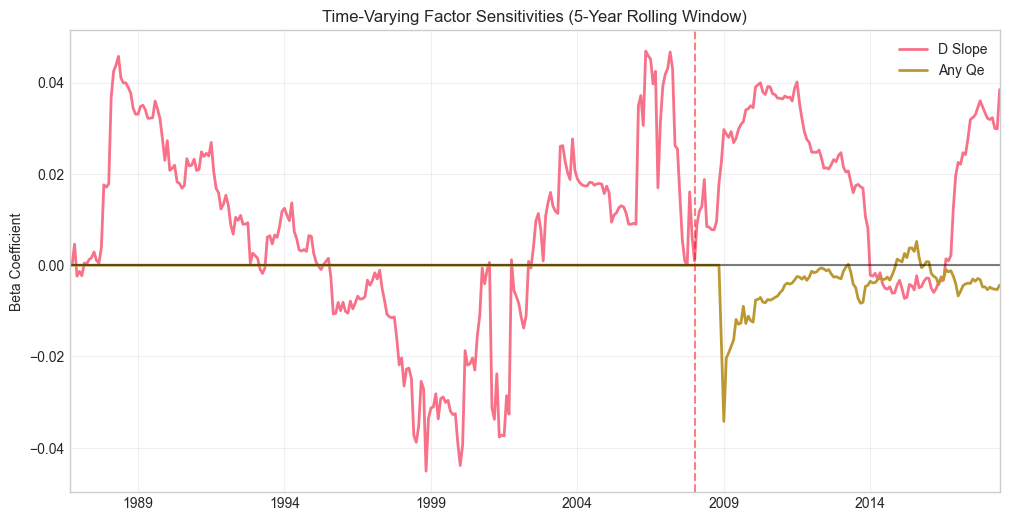

In [112]:
# %% [markdown]
# ## Cell 9: Integrated Analysis - Putting It All Together

# %%
# Combine all factors for integrated analysis
print("Running integrated analysis...")

# Merge all datasets
master_df = analysis_df2[['long_short_return', 'long_return', 'short_return']].copy()

# Add term structure variables
ts_vars = ['level', 'slope', 'd_level', 'd_slope', 'low_rate']
for var in ts_vars:
    if var in analysis_df2.columns:
        master_df[var] = analysis_df2[var]

# Add QE variables
qe_vars = ['any_qe', 'fed_assets_growth']
for var in qe_vars:
    if var in analysis_df2.columns:
        master_df[var] = analysis_df2[var]

# Add crowding measures
if 'crowding_index_ma' in crowding.columns:
    master_df = pd.merge(
        master_df,
        crowding[['crowding_index_ma', 'ret_dispersion']],
        left_index=True, right_index=True, how='left'
    )

print(f"Master dataset: {len(master_df)} observations")
print(f"Variables: {list(master_df.columns)}")

# %%
# Horse race regression: Which factors matter most?

print("HORSE RACE REGRESSION - All Factors")
print("=" * 70)

# Select variables for regression
regression_vars = []
if 'd_level' in master_df.columns:
    regression_vars.append('d_level')
if 'd_slope' in master_df.columns:
    regression_vars.append('d_slope')
if 'any_qe' in master_df.columns:
    regression_vars.append('any_qe')
if 'fed_assets_growth' in master_df.columns:
    regression_vars.append('fed_assets_growth')
if 'crowding_index_ma' in master_df.columns:
    regression_vars.append('crowding_index_ma')

# Run regression
if regression_vars:
    # Remove missing values
    reg_data = master_df[['long_short_return'] + regression_vars].dropna()
    
    X = sm.add_constant(reg_data[regression_vars])
    y = reg_data['long_short_return']
    
    model_all = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
    print(model_all.summary())
    
    # Calculate standardized coefficients
    print("\nStandardized Coefficients (for comparison):")
    print("-" * 50)
    for var in regression_vars:
        if var in model_all.params:
            std_coef = model_all.params[var] * reg_data[var].std() / reg_data['long_short_return'].std()
            print(f"{var:20s}: {std_coef:7.4f}")

# %%
# Variance decomposition: What explains the post-2008 decline?

print("\nVARIANCE DECOMPOSITION")
print("=" * 70)
print("Contribution to post-2008 HML underperformance:\n")

# Split pre/post 2008
pre_2008 = master_df[master_df.index < '2008-01-01']
post_2008 = master_df[master_df.index >= '2008-01-01']

# Calculate actual difference
actual_diff = post_2008['long_short_return'].mean() - pre_2008['long_short_return'].mean()
print(f"Actual HML difference (post-pre 2008): {actual_diff:.4f}")
print(f"  Pre-2008 mean:  {pre_2008['long_short_return'].mean():.4f}")
print(f"  Post-2008 mean: {post_2008['long_short_return'].mean():.4f}")

# Calculate contributions
print("\nFactor contributions:")
print("-" * 50)

contributions = {}
for var in regression_vars:
    if var in model_all.params and not pd.isna(model_all.params[var]):
        # Change in factor mean
        pre_mean = pre_2008[var].mean()
        post_mean = post_2008[var].mean()
        mean_diff = post_mean - pre_mean
        
        # Contribution = coefficient × change in mean
        contribution = model_all.params[var] * mean_diff
        contributions[var] = contribution
        
        print(f"{var:20s}: {contribution:7.4f} ({contribution/actual_diff*100:5.1f}%)")
        print(f"  Factor change: {mean_diff:7.4f}")
        print(f"  Coefficient:   {model_all.params[var]:7.4f}")

total_explained = sum(contributions.values())
print(f"\nTotal explained: {total_explained:.4f} ({total_explained/actual_diff*100:.1f}%)")
print(f"Unexplained:     {actual_diff - total_explained:.4f} ({(actual_diff - total_explained)/actual_diff*100:.1f}%)")

# %%
# Time-varying importance of factors

print("\nAnalyzing time-varying factor importance...")

# Calculate rolling betas
window = 60  # 5-year rolling window
rolling_betas = pd.DataFrame(index=master_df.index[window:])

for var in ['d_slope', 'any_qe', 'crowding_index_ma']:
    if var in master_df.columns:
        betas = []
        
        for i in range(window, len(master_df)):
            # Get rolling window
            window_data = master_df.iloc[i-window:i]
            
            # Simple regression
            try:
                X = sm.add_constant(window_data[var].dropna())
                y = window_data.loc[X.index, 'long_short_return']
                
                if len(X) > 20:  # Need enough observations
                    model = sm.OLS(y, X).fit()
                    betas.append(model.params[var])
                else:
                    betas.append(np.nan)
            except:
                betas.append(np.nan)
        
        rolling_betas[f'beta_{var}'] = betas

# Plot rolling betas
if len(rolling_betas.columns) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for col in rolling_betas.columns:
        if col.startswith('beta_'):
            label = col.replace('beta_', '').replace('_', ' ').title()
            rolling_betas[col].plot(ax=ax, linewidth=2, label=label)
    
    ax.axhline(0, color='black', linestyle='-', alpha=0.5)
    ax.axvline(pd.Timestamp('2008-01-01'), color='red', linestyle='--', alpha=0.5)
    ax.set_title('Time-Varying Factor Sensitivities (5-Year Rolling Window)')
    ax.set_ylabel('Beta Coefficient')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()


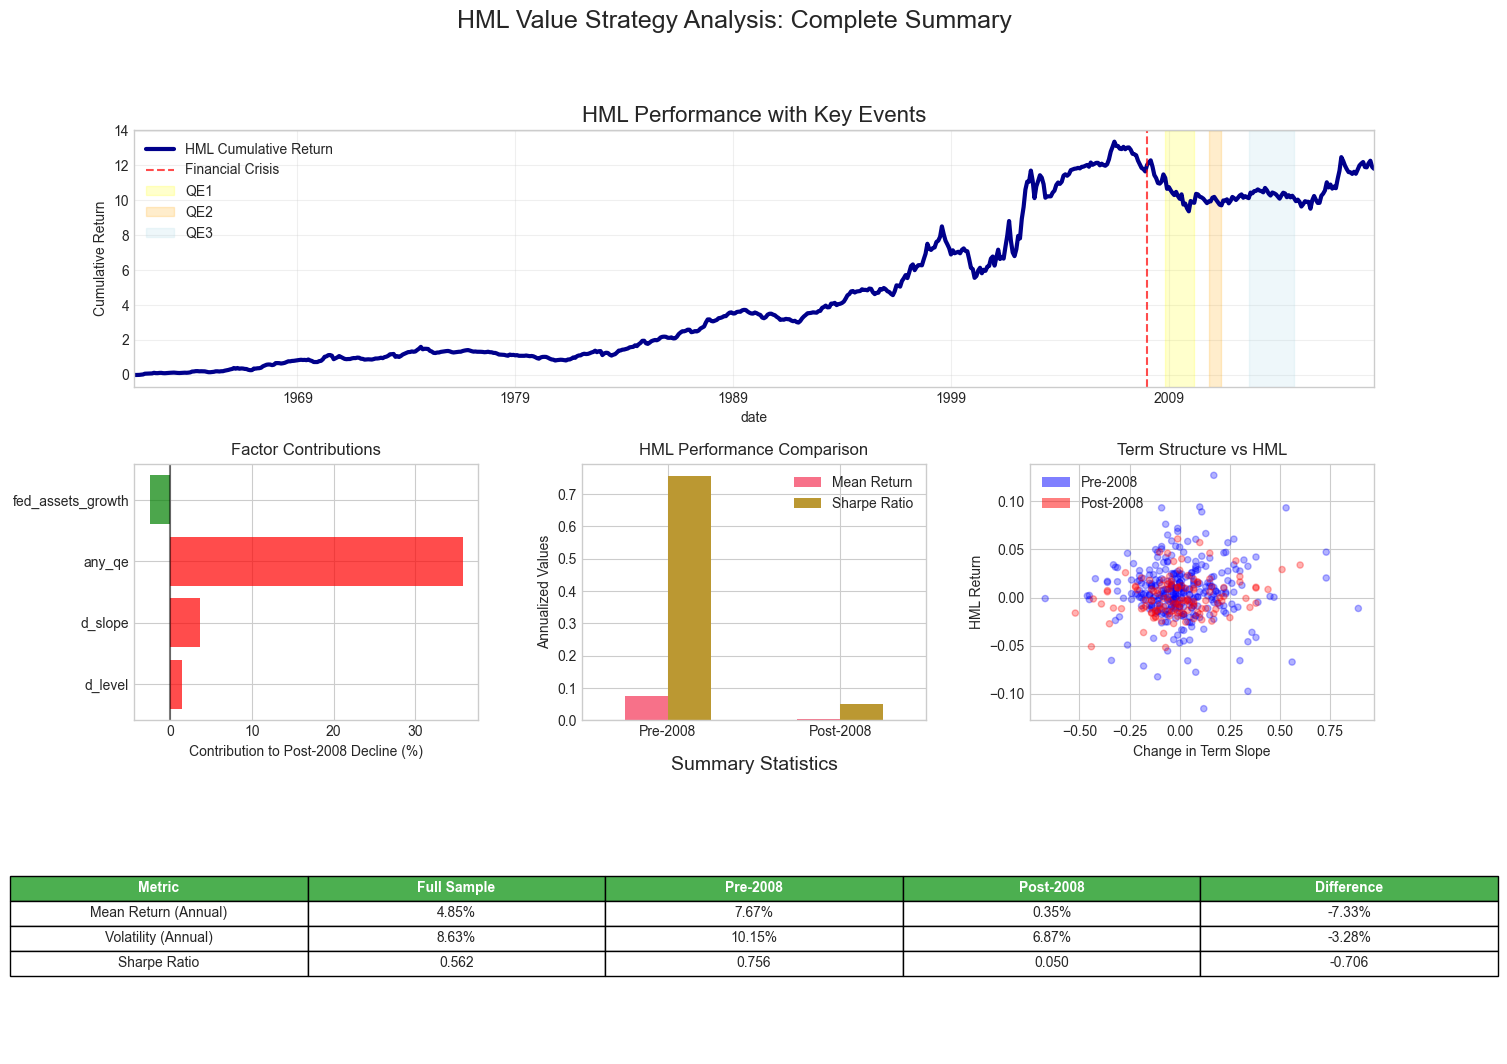

In [118]:
# %% [markdown]
# ## Cell 10: Summary and Conclusions

# %%
# Create summary visualization
fig = plt.figure(figsize=(16, 12))

# Define grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Main performance chart
ax1 = fig.add_subplot(gs[0, :])
hml_returns['cumulative'].plot(ax=ax1, linewidth=3, color='darkblue', label='HML Cumulative Return')

# Add regime markers
ax1.axvline(pd.Timestamp('2008-01-01'), color='red', linestyle='--', alpha=0.7, label='Financial Crisis')
ax1.axvspan('2008-11-25', '2010-03-31', alpha=0.2, color='yellow', label='QE1')
ax1.axvspan('2010-11-03', '2011-06-30', alpha=0.2, color='orange', label='QE2')
ax1.axvspan('2012-09-13', '2014-10-29', alpha=0.2, color='lightblue', label='QE3')

ax1.set_title('HML Performance with Key Events', fontsize=16)
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Factor contributions
ax2 = fig.add_subplot(gs[1, 0])
if contributions:
    contrib_df = pd.DataFrame(list(contributions.items()), columns=['Factor', 'Contribution'])
    contrib_df['Contribution_pct'] = contrib_df['Contribution'] / actual_diff * 100
    
    colors = ['red' if x < 0 else 'green' for x in contrib_df['Contribution']]
    ax2.barh(contrib_df['Factor'], contrib_df['Contribution_pct'], color=colors, alpha=0.7)
    ax2.set_xlabel('Contribution to Post-2008 Decline (%)')
    ax2.set_title('Factor Contributions')
    ax2.axvline(0, color='black', linestyle='-', alpha=0.5)

# 3. Pre vs Post 2008 comparison
ax3 = fig.add_subplot(gs[1, 1])
comparison_data = {
    'Pre-2008': {
        'Mean': pre_2008['long_short_return'].mean() * 12,
        'Volatility': pre_2008['long_short_return'].std() * np.sqrt(12),
        'Sharpe': pre_2008['long_short_return'].mean() / pre_2008['long_short_return'].std() * np.sqrt(12)
    },
    'Post-2008': {
        'Mean': post_2008['long_short_return'].mean() * 12,
        'Volatility': post_2008['long_short_return'].std() * np.sqrt(12),
        'Sharpe': post_2008['long_short_return'].mean() / post_2008['long_short_return'].std() * np.sqrt(12)
    }
}

comp_df = pd.DataFrame(comparison_data).T
comp_df[['Mean', 'Sharpe']].plot(kind='bar', ax=ax3)
ax3.set_title('HML Performance Comparison')
ax3.set_ylabel('Annualized Values')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
ax3.legend(['Mean Return', 'Sharpe Ratio'])

# 4. Key relationships
ax4 = fig.add_subplot(gs[1, 2])
if 'd_slope' in master_df.columns and 'long_short_return' in master_df.columns:
    # Show term structure relationship
    scatter_data = master_df[['d_slope', 'long_short_return']].dropna()
    
    # Color by pre/post 2008
    colors = ['blue' if idx < pd.Timestamp('2008-01-01') else 'red' for idx in scatter_data.index]
    ax4.scatter(scatter_data['d_slope'], scatter_data['long_short_return'], c=colors, alpha=0.3, s=20)
    
    ax4.set_xlabel('Change in Term Slope')
    ax4.set_ylabel('HML Return')
    ax4.set_title('Term Structure vs HML')
    
    # Add legend
    blue_patch = plt.Rectangle((0,0),1,1,fc="blue", alpha=0.5)
    red_patch = plt.Rectangle((0,0),1,1,fc="red", alpha=0.5)
    ax4.legend([blue_patch, red_patch], ['Pre-2008', 'Post-2008'])

# 5. Summary statistics table
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('tight')
ax5.axis('off')

# Create summary table
summary_stats = []
summary_stats.append(['Metric', 'Full Sample', 'Pre-2008', 'Post-2008', 'Difference'])
summary_stats.append(['Mean Return (Annual)', 
                     f"{ls_ret_df['long_short_return'].mean()*12:.2%}",
                     f"{pre_2008['long_short_return'].mean()*12:.2%}",
                     f"{post_2008['long_short_return'].mean()*12:.2%}",
                     f"{(post_2008['long_short_return'].mean() - pre_2008['long_short_return'].mean())*12:.2%}"])
summary_stats.append(['Volatility (Annual)', 
                     f"{ls_ret_df['long_short_return'].std()*np.sqrt(12):.2%}",
                     f"{pre_2008['long_short_return'].std()*np.sqrt(12):.2%}",
                     f"{post_2008['long_short_return'].std()*np.sqrt(12):.2%}",
                     f"{(post_2008['long_short_return'].std() - pre_2008['long_short_return'].std())*np.sqrt(12):.2%}"])
summary_stats.append(['Sharpe Ratio', 
                     f"{ls_ret_df['long_short_return'].mean()/ls_ret_df['long_short_return'].std()*np.sqrt(12):.3f}",
                     f"{pre_2008['long_short_return'].mean()/pre_2008['long_short_return'].std()*np.sqrt(12):.3f}",
                     f"{post_2008['long_short_return'].mean()/post_2008['long_short_return'].std()*np.sqrt(12):.3f}",
                     f"{(post_2008['long_short_return'].mean()/post_2008['long_short_return'].std() - pre_2008['long_short_return'].mean()/pre_2008['long_short_return'].std())*np.sqrt(12):.3f}"])

table = ax5.table(cellText=summary_stats, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

# Style the header row
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax5.set_title('Summary Statistics', fontsize=14, pad=20)

plt.suptitle('HML Value Strategy Analysis: Complete Summary', fontsize=18, y=0.98)
plt.tight_layout()
plt.show()
